In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')
import os
import joblib


In [3]:
df = pd.read_csv('data/drug_consumption.csv')

In [4]:
feature_columns = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 
                  'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']
drug_columns = ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc',
                'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD',
                'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']


In [5]:
def train_evaluate_models(X, y, drug_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'SVM': SVC(),
        'Perceptron': Perceptron()
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store both metrics in results
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1
        }
        
        print(f"\n{drug_name} - {name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return results

In [6]:
all_results = {}

X = df[feature_columns]
for drug in drug_columns:
    print(f"\n{'='*50}")
    print(f"Predicting {drug} usage")
    print('='*50)
    
    y = df[drug]
    results = train_evaluate_models(X, y, drug)
    all_results[drug] = results

# Create separate dictionaries for accuracy and F1 scores
accuracy_dict = {}
f1_dict = {}

for drug in drug_columns:
    accuracy_dict[drug] = {model: scores['accuracy'] for model, scores in all_results[drug].items()}
    f1_dict[drug] = {model: scores['f1_score'] for model, scores in all_results[drug].items()}

# Create separate DataFrames
accuracy_df = pd.DataFrame(accuracy_dict)
f1_df = pd.DataFrame(f1_dict)

# Find best models based on accuracy
best_models = {}
for drug in drug_columns:
    best_model = max(accuracy_dict[drug].items(), key=lambda x: x[1])
    best_models[drug] = best_model

print("\n\nBest Models for Each Drug (Based on Accuracy):")
print('='*50)
for drug, (model, accuracy) in best_models.items():
    print(f"{drug}: {model} (Accuracy: {accuracy:.4f})")

# Optionally, you can also find best models based on F1 score
best_models_f1 = {}
for drug in drug_columns:
    best_model = max(f1_dict[drug].items(), key=lambda x: x[1])
    best_models_f1[drug] = best_model

print("\n\nBest Models for Each Drug (Based on F1 Score):")
print('='*50)
for drug, (model, f1) in best_models_f1.items():
    print(f"{drug}: {model} (F1 Score: {f1:.4f})")


Predicting Alcohol usage

Alcohol - Logistic Regression Results:
Accuracy: 0.3952
F1 Score: 0.2990

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         7
         CL1       0.00      0.00      0.00         7
         CL2       0.00      0.00      0.00        16
         CL3       0.14      0.06      0.08        34
         CL4       0.33      0.01      0.03        68
         CL5       0.42      0.84      0.56       153
         CL6       0.34      0.20      0.25        92

    accuracy                           0.40       377
   macro avg       0.18      0.16      0.13       377
weighted avg       0.33      0.40      0.30       377


Alcohol - Decision Tree Results:
Accuracy: 0.2785
F1 Score: 0.2785

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         7
         CL1       0.00      0.00      0.00         7
         CL2       0.00 

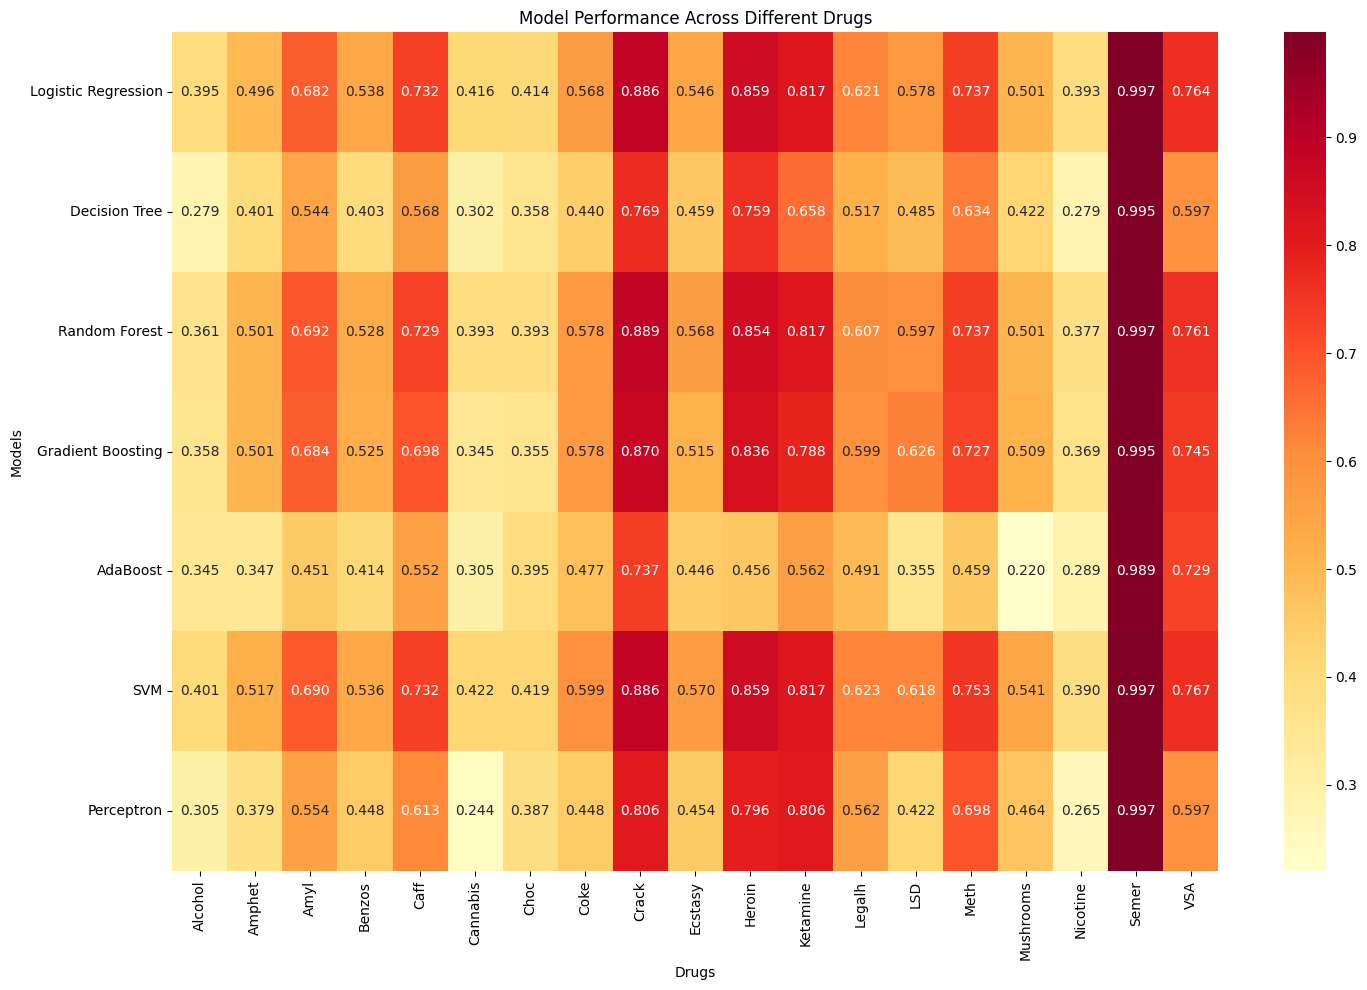

In [ ]:

plt.figure(figsize=(15, 10))
sns.heatmap(accuracy_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Model Performance Across Different Drugs(accuracy)')
plt.ylabel('Models')
plt.xlabel('Drugs')
plt.tight_layout()
plt.show()

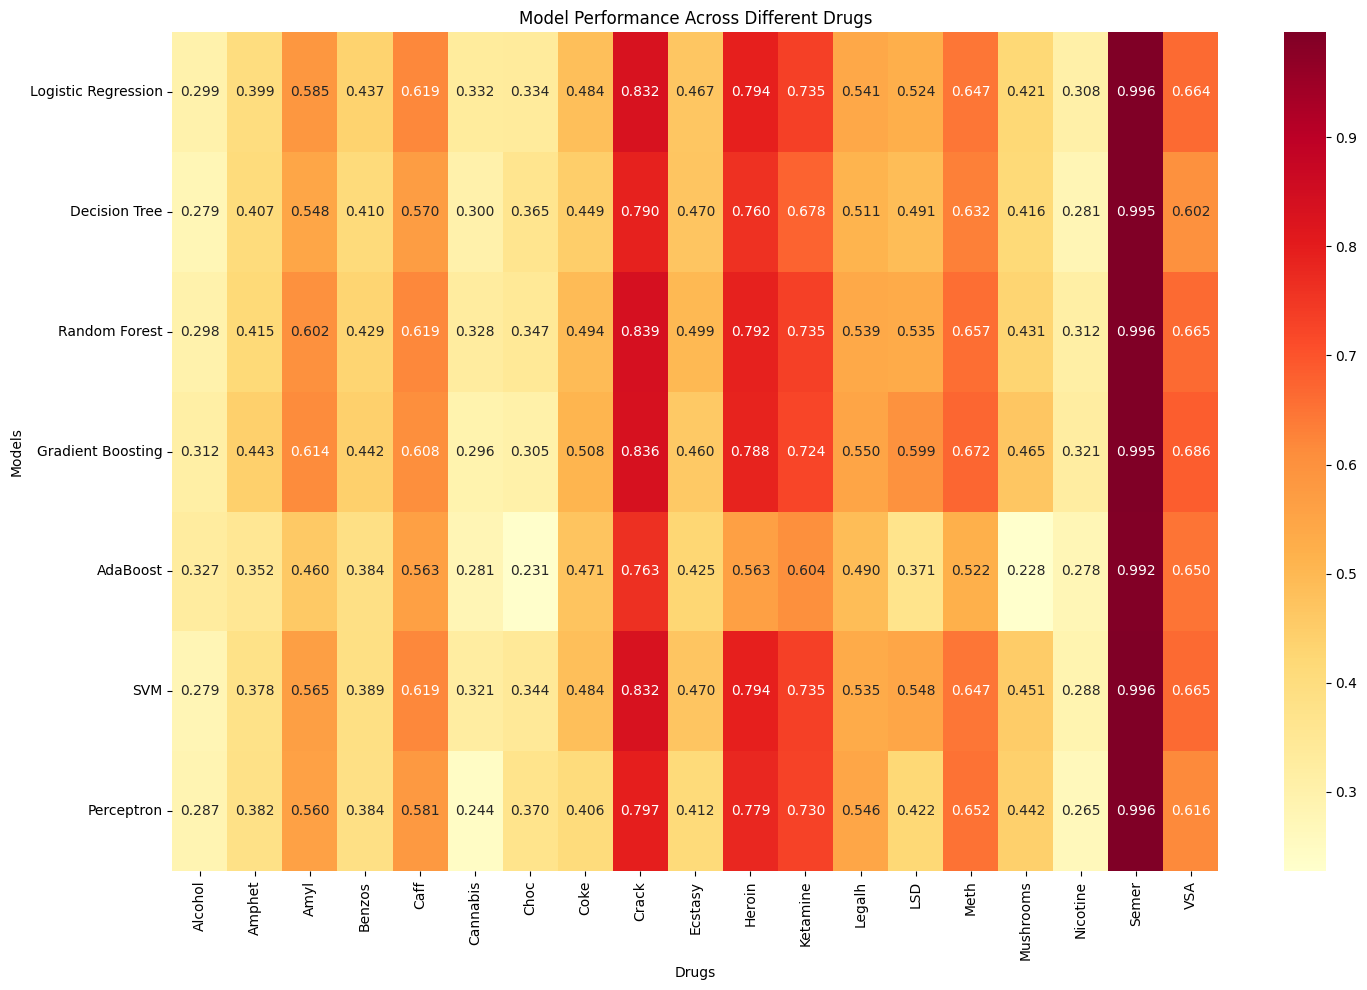

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(f1_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Model Performance Across Different Drugs(f1 score)')
plt.ylabel('Models')
plt.xlabel('Drugs')
plt.tight_layout()
plt.show()

In [11]:

param_distributions = {
    'Logistic Regression': {
        'C': uniform(0.1, 10),
        'max_iter': [1000],
        'solver': ['lbfgs', 'liblinear', 'sag'],
        'class_weight': ['balanced', None]
    },
    'Decision Tree': {
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    },
    'Gradient Boosting': {
        'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 20)
    },
    'AdaBoost': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 1)
    },
    'SVM': {
        'C': uniform(0.1, 10),
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    'Perceptron': {
        'max_iter': randint(500, 2000),
        'eta0': uniform(0.1, 1.0),
        'penalty': [None, 'l2', 'l1'],
        'alpha': uniform(0.0001, 0.01)
    }
}

In [12]:
def train_evaluate_models(X, y, drug_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'SVM': SVC(),
        'Perceptron': Perceptron()
    }
    
    results = {}
    best_params = {}
    
    for name, model in models.items():
        print(f"\nTraining {name} for {drug_name}")
        
        random_search = RandomizedSearchCV(
            model,
            param_distributions[name],
            n_iter=15,
            cv=5,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        random_search.fit(X_train, y_train)
        
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Calculate both accuracy and F1 score
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store both metrics in results
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1
        }
        
        best_params[name] = random_search.best_params_
        
        print(f"Best parameters: {random_search.best_params_}")
        print(f"Best accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return results, best_params

In [13]:
all_results = {}
all_best_params = {}

X = df[feature_columns]
for drug in drug_columns:
    print(f"\n{'='*50}")
    print(f"Predicting {drug} usage")
    print('='*50)
    
    y = df[drug]
    results, best_params = train_evaluate_models(X, y, drug)
    all_results[drug] = results
    all_best_params[drug] = best_params

# Create separate dictionaries for accuracy and F1 scores
accuracy_dict = {}
f1_dict = {}

for drug in drug_columns:
    accuracy_dict[drug] = {model: scores['accuracy'] for model, scores in all_results[drug].items()}
    f1_dict[drug] = {model: scores['f1_score'] for model, scores in all_results[drug].items()}

# Create separate DataFrames
accuracy_df = pd.DataFrame(accuracy_dict)
f1_df = pd.DataFrame(f1_dict)

# Find best models based on accuracy
best_models_accuracy = {}
best_models_f1 = {}

for drug in drug_columns:
    best_model_acc = max(accuracy_dict[drug].items(), key=lambda x: x[1])
    best_model_f1 = max(f1_dict[drug].items(), key=lambda x: x[1])
    best_models_accuracy[drug] = best_model_acc
    best_models_f1[drug] = best_model_f1

print("\n\nBest Models for Each Drug (Based on Accuracy):")
print('='*50)
for drug, (model, accuracy) in best_models_accuracy.items():
    print(f"{drug}: {model} (Accuracy: {accuracy:.4f})")

print("\n\nBest Models for Each Drug (Based on F1 Score):")
print('='*50)
for drug, (model, f1) in best_models_f1.items():
    print(f"{drug}: {model} (F1 Score: {f1:.4f})")


Predicting Alcohol usage

Training Logistic Regression for Alcohol
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.3926
F1 Score: 0.2911

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         7
         CL1       0.00      0.00      0.00         7
         CL2       0.00      0.00      0.00        16
         CL3       0.17      0.06      0.09        34
         CL4       0.00      0.00      0.00        68
         CL5       0.41      0.84      0.56       153
         CL6       0.33      0.18      0.24        92

    accuracy                           0.39       377
   macro avg       0.13      0.16      0.13       377
weighted avg       0.26      0.39      0.29       377


Training Decision Tree for Alcohol
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13}
Best accuracy: 0.4058
F1 Score

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.4058
F1 Score: 0.2343

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         7
         CL1       0.00      0.00      0.00         7
         CL2       0.00      0.00      0.00        16
         CL3       0.00      0.00      0.00        34
         CL4       0.00      0.00      0.00        68
         CL5       0.41      1.00      0.58       153
         CL6       0.00      0.00      0.00        92

    accuracy                           0.41       377
   macro avg       0.06      0.14      0.08       377
weighted avg       0.16      0.41      0.23       377


Training SVM for Alcohol
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 3.0214464853521816, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.3793
F1 Score: 0.2918

Classification Report:
              precision    recall  

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.5199
F1 Score: 0.3557

Classification Report:
              precision    recall  f1-score   support

         CL0       0.52      1.00      0.68       196
         CL1       0.00      0.00      0.00        53
         CL2       0.00      0.00      0.00        46
         CL3       0.00      0.00      0.00        42
         CL4       0.00      0.00      0.00        13
         CL5       0.00      0.00      0.00        11
         CL6       0.00      0.00      0.00        16

    accuracy                           0.52       377
   macro avg       0.07      0.14      0.10       377
weighted avg       0.27      0.52      0.36       377


Training SVM for Amphet
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 0.6808361216819946, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.5172
F1 Score: 0.3551

Classification Report:
              precision    recall  f

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.6923
F1 Score: 0.5915

Classification Report:
              precision    recall  f1-score   support

         CL0       0.71      0.98      0.82       261
         CL1       0.40      0.04      0.08        45
         CL2       0.30      0.07      0.11        44
         CL3       0.00      0.00      0.00        20
         CL4       0.00      0.00      0.00         6
         CL5       0.00      0.00      0.00         1

    accuracy                           0.69       377
   macro avg       0.23      0.18      0.17       377
weighted avg       0.57      0.69      0.59       377


Training Decision Tree for Amyl
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best accuracy: 0.6950
F1 Score: 0.5851

Classification Report:
              precision 

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.6923
F1 Score: 0.5664

Classification Report:
              precision    recall  f1-score   support

         CL0       0.69      1.00      0.82       261
         CL1       0.00      0.00      0.00        45
         CL2       0.00      0.00      0.00        44
         CL3       0.00      0.00      0.00        20
         CL4       0.00      0.00      0.00         6
         CL5       0.00      0.00      0.00         1

    accuracy                           0.69       377
   macro avg       0.12      0.17      0.14       377
weighted avg       0.48      0.69      0.57       377


Training SVM for Amyl
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 1.6601864044243653, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.6923
F1 Score: 0.5767

Classification Report:
              precision    recall  f1-score   support

         CL0       0.70      0.99   

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.5385
F1 Score: 0.3769

Classification Report:
              precision    recall  f1-score   support

         CL0       0.54      1.00      0.70       203
         CL1       0.00      0.00      0.00        21
         CL2       0.00      0.00      0.00        38
         CL3       0.00      0.00      0.00        51
         CL4       0.00      0.00      0.00        27
         CL5       0.00      0.00      0.00        15
         CL6       0.00      0.00      0.00        22

    accuracy                           0.54       377
   macro avg       0.08      0.14      0.10       377
weighted avg       0.29      0.54      0.38       377


Training SVM for Benzos
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 0.30584494295802445, 'gamma': 'auto', 'kernel': 'linear'}
Best accuracy: 0.5385
F1 Score: 0.3769

Classification Report:
              precision    recal

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.6808361216819946, 'class_weight': None, 'max_iter': 1000, 'solver': 'lbfgs'}
Best accuracy: 0.7321
F1 Score: 0.6189

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         5
         CL1       0.00      0.00      0.00         3
         CL2       0.00      0.00      0.00         7
         CL3       0.00      0.00      0.00        13
         CL4       0.00      0.00      0.00        21
         CL5       0.00      0.00      0.00        52
         CL6       0.73      1.00      0.85       276

    accuracy                           0.73       377
   macro avg       0.10      0.14      0.12       377
weighted avg       0.54      0.73      0.62       377


Training Decision Tree for Caff
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13}
Best accuracy: 0.7268
F1 Score: 0.6172

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.06808361216819946, 'n_estimators': 137}
Best accuracy: 0.7321
F1 Score: 0.6189

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         5
         CL1       0.00      0.00      0.00         3
         CL2       0.00      0.00      0.00         7
         CL3       0.00      0.00      0.00        13
         CL4       0.00      0.00      0.00        21
         CL5       0.00      0.00      0.00        52
         CL6       0.73      1.00      0.85       276

    accuracy                           0.73       377
   macro avg       0.10      0.14      0.12       377
weighted avg       0.54      0.73      0.62       377


Training SVM for Caff
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 1.6601864044243653, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.7321
F1 Score: 0.6189

Classification Report:
              precision    recall  f1-

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.1934347898661638, 'n_estimators': 121}
Best accuracy: 0.3873
F1 Score: 0.3189

Classification Report:
              precision    recall  f1-score   support

         CL0       0.45      0.58      0.51        86
         CL1       0.17      0.29      0.22        28
         CL2       0.21      0.16      0.19        55
         CL3       0.40      0.07      0.12        57
         CL4       0.00      0.00      0.00        27
         CL5       0.00      0.00      0.00        32
         CL6       0.45      0.82      0.58        92

    accuracy                           0.39       377
   macro avg       0.24      0.27      0.23       377
weighted avg       0.32      0.39      0.32       377


Training SVM for Cannabis
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 0.30584494295802445, 'gamma': 'auto', 'kernel': 'linear'}
Best accuracy: 0.4244
F1 Score: 0.3099

Classification Report:
              precision    recal

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.4138
F1 Score: 0.3339

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         4
         CL2       0.00      0.00      0.00         3
         CL3       0.00      0.00      0.00         9
         CL4       0.00      0.00      0.00        52
         CL5       0.38      0.19      0.26       156
         CL6       0.43      0.82      0.56       153

    accuracy                           0.41       377
   macro avg       0.14      0.17      0.14       377
weighted avg       0.33      0.41      0.33       377


Training Decision Tree for Choc
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best accuracy: 0.4058
F1 Score: 0.3511

Classification Report:
              precision 

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.4111
F1 Score: 0.2786

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         4
         CL2       0.00      0.00      0.00         3
         CL3       0.00      0.00      0.00         9
         CL4       0.00      0.00      0.00        52
         CL5       0.42      0.06      0.11       156
         CL6       0.41      0.95      0.57       153

    accuracy                           0.41       377
   macro avg       0.14      0.17      0.11       377
weighted avg       0.34      0.41      0.28       377


Training SVM for Choc
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 0.6808361216819946, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.4111
F1 Score: 0.3188

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00    

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.5623
F1 Score: 0.4703

Classification Report:
              precision    recall  f1-score   support

         CL0       0.63      0.91      0.75       224
         CL1       0.33      0.07      0.11        30
         CL2       0.11      0.02      0.04        44
         CL3       0.13      0.12      0.12        43
         CL4       0.00      0.00      0.00        25
         CL5       0.00      0.00      0.00         8
         CL6       0.00      0.00      0.00         3

    accuracy                           0.56       377
   macro avg       0.17      0.16      0.15       377
weighted avg       0.43      0.56      0.47       377


Training Decision Tree for Coke
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best accuracy: 0.5889
F1 Score: 0

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.03306242504141576, 'n_estimators': 268}
Best accuracy: 0.5809
F1 Score: 0.4583

Classification Report:
              precision    recall  f1-score   support

         CL0       0.61      0.96      0.74       224
         CL1       0.00      0.00      0.00        30
         CL2       0.00      0.00      0.00        44
         CL3       0.20      0.12      0.15        43
         CL4       0.00      0.00      0.00        25
         CL5       0.00      0.00      0.00         8
         CL6       0.00      0.00      0.00         3

    accuracy                           0.58       377
   macro avg       0.12      0.15      0.13       377
weighted avg       0.38      0.58      0.46       377


Training SVM for Coke
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 0.6808361216819946, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.5995
F1 Score: 0.4563

Classification Report:
              precision    recall  f1-s

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.8859
F1 Score: 0.8324

Classification Report:
              precision    recall  f1-score   support

         CL0       0.89      1.00      0.94       334
         CL1       0.00      0.00      0.00         8
         CL2       0.00      0.00      0.00        22
         CL3       0.00      0.00      0.00         9
         CL4       0.00      0.00      0.00         2
         CL5       0.00      0.00      0.00         1
         CL6       0.00      0.00      0.00         1

    accuracy                           0.89       377
   macro avg       0.13      0.14      0.13       377
weighted avg       0.78      0.89      0.83       377


Training Decision Tree for Crack
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13}
Best accuracy: 0.8859
F1 Score: 

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.8859
F1 Score: 0.8324

Classification Report:
              precision    recall  f1-score   support

         CL0       0.89      1.00      0.94       334
         CL1       0.00      0.00      0.00         8
         CL2       0.00      0.00      0.00        22
         CL3       0.00      0.00      0.00         9
         CL4       0.00      0.00      0.00         2
         CL5       0.00      0.00      0.00         1
         CL6       0.00      0.00      0.00         1

    accuracy                           0.89       377
   macro avg       0.13      0.14      0.13       377
weighted avg       0.78      0.89      0.83       377


Training SVM for Crack
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 1.6601864044243653, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.8859
F1 Score: 0.8324

Classification Report:
              precision    recall  f

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.5517
F1 Score: 0.4649

Classification Report:
              precision    recall  f1-score   support

         CL0       0.61      0.89      0.73       208
         CL1       0.00      0.00      0.00        22
         CL2       0.17      0.02      0.04        43
         CL3       0.30      0.31      0.30        62
         CL4       0.50      0.07      0.12        30
         CL5       0.00      0.00      0.00         9
         CL6       0.00      0.00      0.00         3

    accuracy                           0.55       377
   macro avg       0.23      0.18      0.17       377
weighted avg       0.45      0.55      0.46       377


Training Decision Tree for Ecstasy
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best accuracy: 0.5385
F1 Score

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.06641157902710025, 'n_estimators': 137}
Best accuracy: 0.5544
F1 Score: 0.4459

Classification Report:
              precision    recall  f1-score   support

         CL0       0.59      0.93      0.72       208
         CL1       0.25      0.05      0.08        22
         CL2       0.00      0.00      0.00        43
         CL3       0.33      0.23      0.27        62
         CL4       0.00      0.00      0.00        30
         CL5       0.00      0.00      0.00         9
         CL6       0.00      0.00      0.00         3

    accuracy                           0.55       377
   macro avg       0.17      0.17      0.15       377
weighted avg       0.39      0.55      0.45       377


Training SVM for Ecstasy
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 4.660699842170359, 'gamma': 'scale', 'kernel': 'linear'}
Best accuracy: 0.5491
F1 Score: 0.4447

Classification Report:
              precision    recall

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.8594
F1 Score: 0.7944

Classification Report:
              precision    recall  f1-score   support

         CL0       0.86      1.00      0.92       324
         CL1       0.00      0.00      0.00        11
         CL2       0.00      0.00      0.00        18
         CL3       0.00      0.00      0.00        12
         CL4       0.00      0.00      0.00         6
         CL5       0.00      0.00      0.00         4
         CL6       0.00      0.00      0.00         2

    accuracy                           0.86       377
   macro avg       0.12      0.14      0.13       377
weighted avg       0.74      0.86      0.79       377


Training Decision Tree for Heroin
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13}
Best accuracy: 0.8594
F1 Score:

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.8594
F1 Score: 0.7944

Classification Report:
              precision    recall  f1-score   support

         CL0       0.86      1.00      0.92       324
         CL1       0.00      0.00      0.00        11
         CL2       0.00      0.00      0.00        18
         CL3       0.00      0.00      0.00        12
         CL4       0.00      0.00      0.00         6
         CL5       0.00      0.00      0.00         4
         CL6       0.00      0.00      0.00         2

    accuracy                           0.86       377
   macro avg       0.12      0.14      0.13       377
weighted avg       0.74      0.86      0.79       377


Training SVM for Heroin
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 1.6601864044243653, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.8594
F1 Score: 0.7944

Classification Report:
              precision    recall  

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.5666566321361542, 'class_weight': None, 'max_iter': 1000, 'solver': 'sag'}
Best accuracy: 0.8170
F1 Score: 0.7347

Classification Report:
              precision    recall  f1-score   support

         CL0       0.82      1.00      0.90       308
         CL1       0.00      0.00      0.00         4
         CL2       0.00      0.00      0.00        22
         CL3       0.00      0.00      0.00        23
         CL4       0.00      0.00      0.00         8
         CL5       0.00      0.00      0.00        11
         CL6       0.00      0.00      0.00         1

    accuracy                           0.82       377
   macro avg       0.12      0.14      0.13       377
weighted avg       0.67      0.82      0.73       377


Training Decision Tree for Ketamine
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13}
Best accuracy: 0.8170
F1 Score: 0.73

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.8170
F1 Score: 0.7347

Classification Report:
              precision    recall  f1-score   support

         CL0       0.82      1.00      0.90       308
         CL1       0.00      0.00      0.00         4
         CL2       0.00      0.00      0.00        22
         CL3       0.00      0.00      0.00        23
         CL4       0.00      0.00      0.00         8
         CL5       0.00      0.00      0.00        11
         CL6       0.00      0.00      0.00         1

    accuracy                           0.82       377
   macro avg       0.12      0.14      0.13       377
weighted avg       0.67      0.82      0.73       377


Training SVM for Ketamine
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 1.6601864044243653, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.8170
F1 Score: 0.7347

Classification Report:
              precision    recall

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 6.274815096277165, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.6260
F1 Score: 0.5406

Classification Report:
              precision    recall  f1-score   support

         CL0       0.72      0.94      0.82       216
         CL1       0.00      0.00      0.00         3
         CL2       0.00      0.00      0.00        42
         CL3       0.35      0.51      0.42        65
         CL4       0.00      0.00      0.00        25
         CL5       0.00      0.00      0.00        15
         CL6       0.00      0.00      0.00        11

    accuracy                           0.63       377
   macro avg       0.15      0.21      0.18       377
weighted avg       0.48      0.63      0.54       377


Training Decision Tree for Legalh
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13}
Best accuracy: 0.6048
F1 Score: 0

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.05666566321361543, 'n_estimators': 237}
Best accuracy: 0.6180
F1 Score: 0.5330

Classification Report:
              precision    recall  f1-score   support

         CL0       0.71      0.92      0.80       216
         CL1       0.00      0.00      0.00         3
         CL2       0.00      0.00      0.00        42
         CL3       0.36      0.52      0.42        65
         CL4       0.00      0.00      0.00        25
         CL5       0.00      0.00      0.00        15
         CL6       0.00      0.00      0.00        11

    accuracy                           0.62       377
   macro avg       0.15      0.21      0.18       377
weighted avg       0.47      0.62      0.53       377


Training SVM for Legalh
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 0.6808361216819946, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.6233
F1 Score: 0.5358

Classification Report:
              precision    recall  f1

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.5889
F1 Score: 0.5241

Classification Report:
              precision    recall  f1-score   support

         CL0       0.66      0.88      0.75       218
         CL1       0.50      0.21      0.30        52
         CL2       0.20      0.04      0.06        28
         CL3       0.32      0.41      0.36        46
         CL4       0.00      0.00      0.00        20
         CL5       0.00      0.00      0.00        11
         CL6       0.00      0.00      0.00         2

    accuracy                           0.59       377
   macro avg       0.24      0.22      0.21       377
weighted avg       0.50      0.59      0.52       377


Training Decision Tree for LSD
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 16}
Best accuracy: 0.5836
F1 Score: 0.

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.06641157902710025, 'n_estimators': 137}
Best accuracy: 0.5756
F1 Score: 0.4928

Classification Report:
              precision    recall  f1-score   support

         CL0       0.62      0.91      0.74       218
         CL1       0.44      0.15      0.23        52
         CL2       0.25      0.04      0.06        28
         CL3       0.27      0.22      0.24        46
         CL4       0.00      0.00      0.00        20
         CL5       0.00      0.00      0.00        11
         CL6       0.00      0.00      0.00         2

    accuracy                           0.58       377
   macro avg       0.23      0.19      0.18       377
weighted avg       0.47      0.58      0.49       377


Training SVM for LSD
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 0.6808361216819946, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.6154
F1 Score: 0.5325

Classification Report:
              precision    recall  f1-sc

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 6.1111501174320875, 'class_weight': None, 'max_iter': 1000, 'solver': 'sag'}
Best accuracy: 0.7347
F1 Score: 0.6455

Classification Report:
              precision    recall  f1-score   support

         CL0       0.76      0.97      0.85       284
         CL1       0.00      0.00      0.00         7
         CL2       0.00      0.00      0.00        20
         CL3       0.08      0.03      0.05        31
         CL4       0.00      0.00      0.00         9
         CL5       0.00      0.00      0.00        14
         CL6       0.00      0.00      0.00        12

    accuracy                           0.73       377
   macro avg       0.12      0.14      0.13       377
weighted avg       0.58      0.73      0.65       377


Training Decision Tree for Meth
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13}
Best accuracy: 0.7533
F1 Score: 0.6473



/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.06808361216819946, 'n_estimators': 137}
Best accuracy: 0.7533
F1 Score: 0.6473

Classification Report:
              precision    recall  f1-score   support

         CL0       0.75      1.00      0.86       284
         CL1       0.00      0.00      0.00         7
         CL2       0.00      0.00      0.00        20
         CL3       0.00      0.00      0.00        31
         CL4       0.00      0.00      0.00         9
         CL5       0.00      0.00      0.00        14
         CL6       0.00      0.00      0.00        12

    accuracy                           0.75       377
   macro avg       0.11      0.14      0.12       377
weighted avg       0.57      0.75      0.65       377


Training SVM for Meth
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 1.6601864044243653, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.7533
F1 Score: 0.6483

Classification Report:
              precision    recall  f1-

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 6.1111501174320875, 'class_weight': None, 'max_iter': 1000, 'solver': 'sag'}
Best accuracy: 0.4987
F1 Score: 0.4194

Classification Report:
              precision    recall  f1-score   support

         CL0       0.58      0.82      0.68       191
         CL1       0.21      0.07      0.11        42
         CL2       0.08      0.02      0.03        51
         CL3       0.34      0.49      0.40        55
         CL4       0.00      0.00      0.00        30
         CL5       0.00      0.00      0.00         6
         CL6       0.00      0.00      0.00         2

    accuracy                           0.50       377
   macro avg       0.17      0.20      0.17       377
weighted avg       0.38      0.50      0.42       377


Training Decision Tree for Mushrooms
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 8}
Best accuracy: 0.5093
F1 Score: 0.4524


/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.5252
F1 Score: 0.3929

Classification Report:
              precision    recall  f1-score   support

         CL0       0.53      0.97      0.69       191
         CL1       0.00      0.00      0.00        42
         CL2       0.00      0.00      0.00        51
         CL3       0.45      0.24      0.31        55
         CL4       0.00      0.00      0.00        30
         CL5       0.00      0.00      0.00         6
         CL6       0.00      0.00      0.00         2

    accuracy                           0.53       377
   macro avg       0.14      0.17      0.14       377
weighted avg       0.33      0.53      0.39       377


Training SVM for Mushrooms
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 1.6601864044243653, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.5252
F1 Score: 0.4442

Classification Report:
              precision    recal

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.05666566321361543, 'n_estimators': 237}
Best accuracy: 0.3714
F1 Score: 0.2814

Classification Report:
              precision    recall  f1-score   support

         CL0       0.38      0.45      0.41        91
         CL1       0.13      0.12      0.12        34
         CL2       0.00      0.00      0.00        44
         CL3       0.00      0.00      0.00        33
         CL4       0.00      0.00      0.00        19
         CL5       0.00      0.00      0.00        34
         CL6       0.40      0.78      0.53       122

    accuracy                           0.37       377
   macro avg       0.13      0.19      0.15       377
weighted avg       0.23      0.37      0.28       377


Training SVM for Nicotine
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 8.424426408004217, 'gamma': 'auto', 'kernel': 'linear'}
Best accuracy: 0.3873
F1 Score: 0.2960

Classification Report:
              precision    recall

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.6808361216819946, 'class_weight': None, 'max_iter': 1000, 'solver': 'lbfgs'}
Best accuracy: 0.9973
F1 Score: 0.9960

Classification Report:
              precision    recall  f1-score   support

         CL0       1.00      1.00      1.00       376
         CL2       0.00      0.00      0.00         1

    accuracy                           1.00       377
   macro avg       0.50      0.50      0.50       377
weighted avg       0.99      1.00      1.00       377


Training Decision Tree for Semer
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 8, 'min_samples_split': 8}
Best accuracy: 0.9973
F1 Score: 0.9960

Classification Report:
              precision    recall  f1-score   support

         CL0       1.00      1.00      1.00       376
         CL2       0.00      0.00      0.00         1

    accuracy                           1.00       377
   macro avg       0.50      

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.9973
F1 Score: 0.9960

Classification Report:
              precision    recall  f1-score   support

         CL0       1.00      1.00      1.00       376
         CL2       0.00      0.00      0.00         1

    accuracy                           1.00       377
   macro avg       0.50      0.50      0.50       377
weighted avg       0.99      1.00      1.00       377


Training SVM for Semer
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 3.845401188473625, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9973
F1 Score: 0.9960

Classification Report:
              precision    recall  f1-score   support

         CL0       1.00      1.00      1.00       376
         CL2       0.00      0.00      0.00         1

    accuracy                           1.00       377
   macro avg       0.50      0.50      0.50       377
weighted avg       0.99      1.00  

/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: Con

Best parameters: {'C': 0.30584494295802445, 'class_weight': None, 'max_iter': 1000, 'solver': 'liblinear'}
Best accuracy: 0.7666
F1 Score: 0.6653

Classification Report:
              precision    recall  f1-score   support

         CL0       0.77      1.00      0.87       289
         CL1       0.00      0.00      0.00        39
         CL2       0.00      0.00      0.00        27
         CL3       0.00      0.00      0.00        12
         CL4       0.00      0.00      0.00         1
         CL5       0.00      0.00      0.00         8
         CL6       0.00      0.00      0.00         1

    accuracy                           0.77       377
   macro avg       0.11      0.14      0.12       377
weighted avg       0.59      0.77      0.67       377


Training Decision Tree for VSA
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13}
Best accuracy: 0.7666
F1 Score: 0.

/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/somay/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

Best parameters: {'learning_rate': 0.010778765841014329, 'n_estimators': 237}
Best accuracy: 0.7666
F1 Score: 0.6653

Classification Report:
              precision    recall  f1-score   support

         CL0       0.77      1.00      0.87       289
         CL1       0.00      0.00      0.00        39
         CL2       0.00      0.00      0.00        27
         CL3       0.00      0.00      0.00        12
         CL4       0.00      0.00      0.00         1
         CL5       0.00      0.00      0.00         8
         CL6       0.00      0.00      0.00         1

    accuracy                           0.77       377
   macro avg       0.11      0.14      0.12       377
weighted avg       0.59      0.77      0.67       377


Training SVM for VSA
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'C': 0.6808361216819946, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.7666
F1 Score: 0.6653

Classification Report:
              precision    recall  f1-s

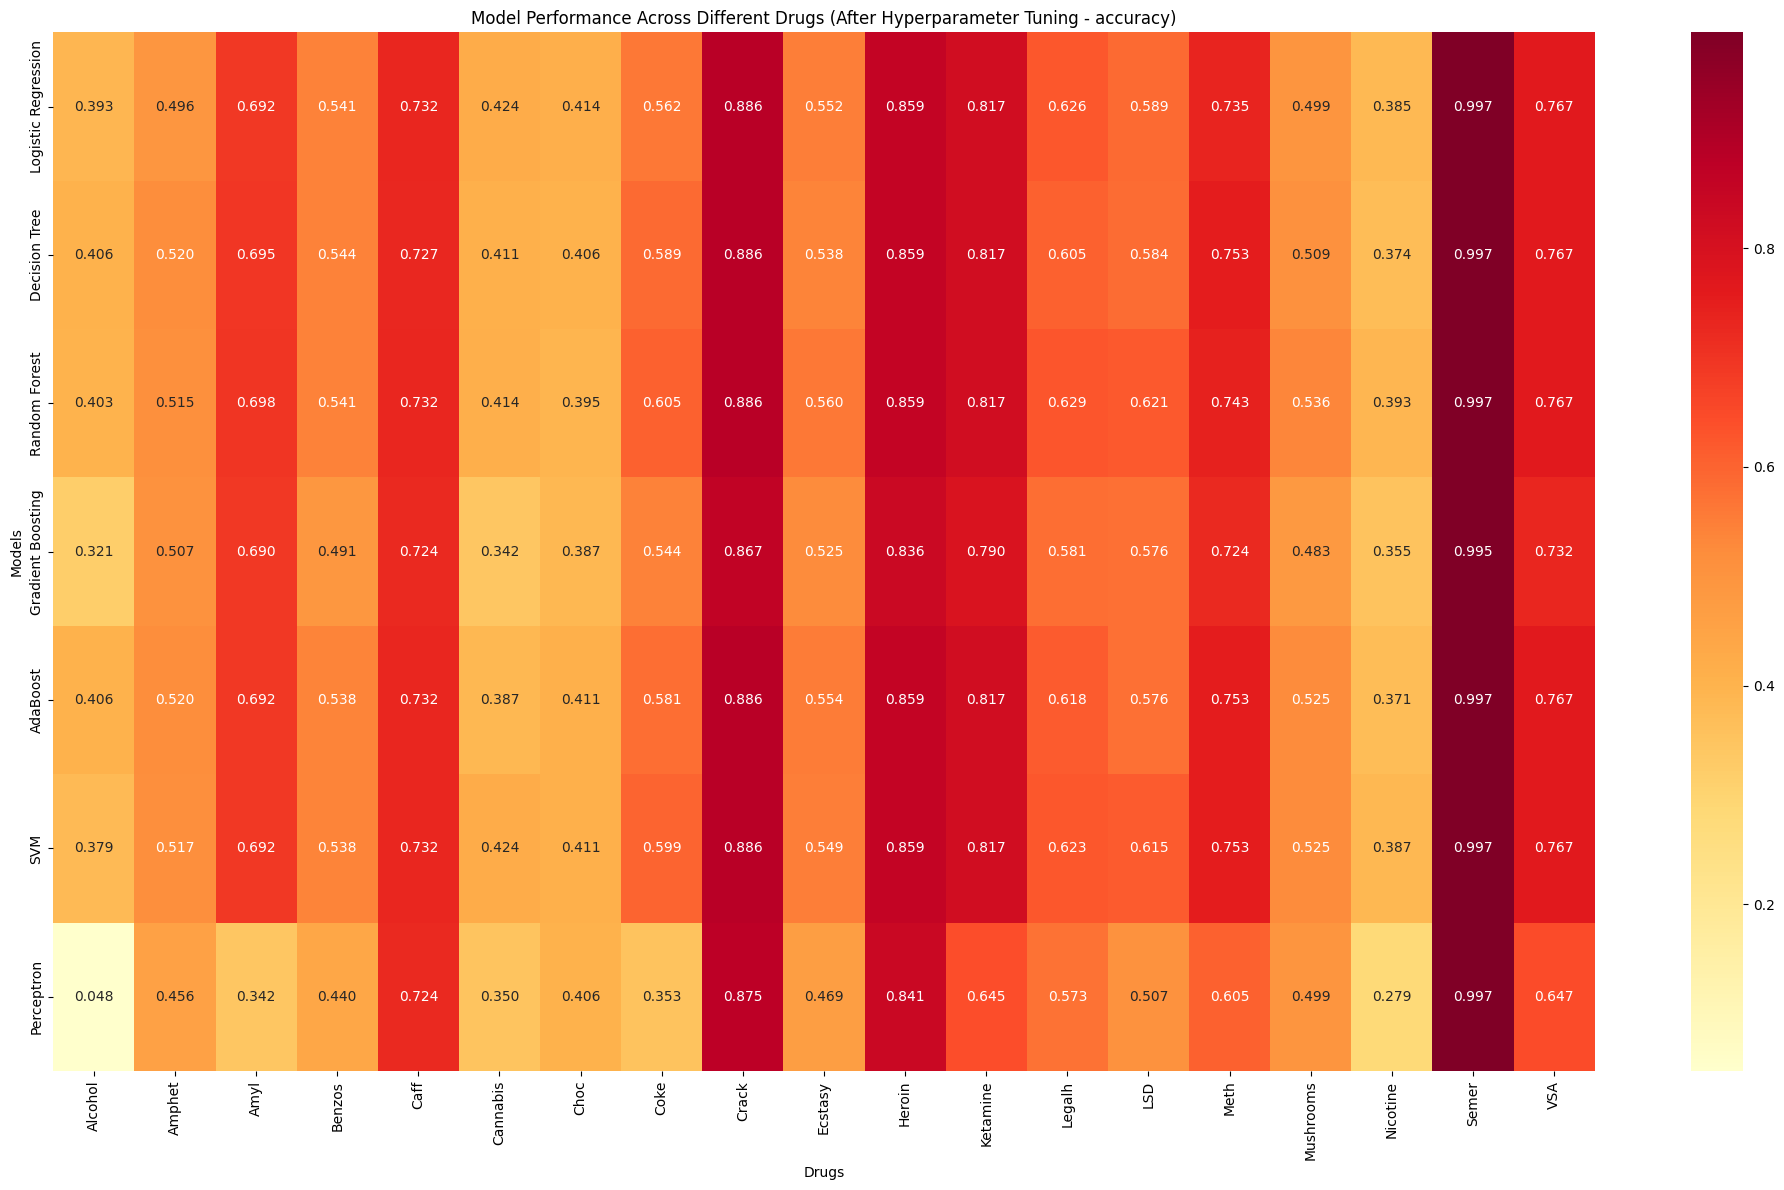

In [14]:
plt.figure(figsize=(20, 12))
sns.heatmap(accuracy_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Model Performance Across Different Drugs (After Hyperparameter Tuning - accuracy)')
plt.ylabel('Models')
plt.xlabel('Drugs')
plt.tight_layout()
plt.show()

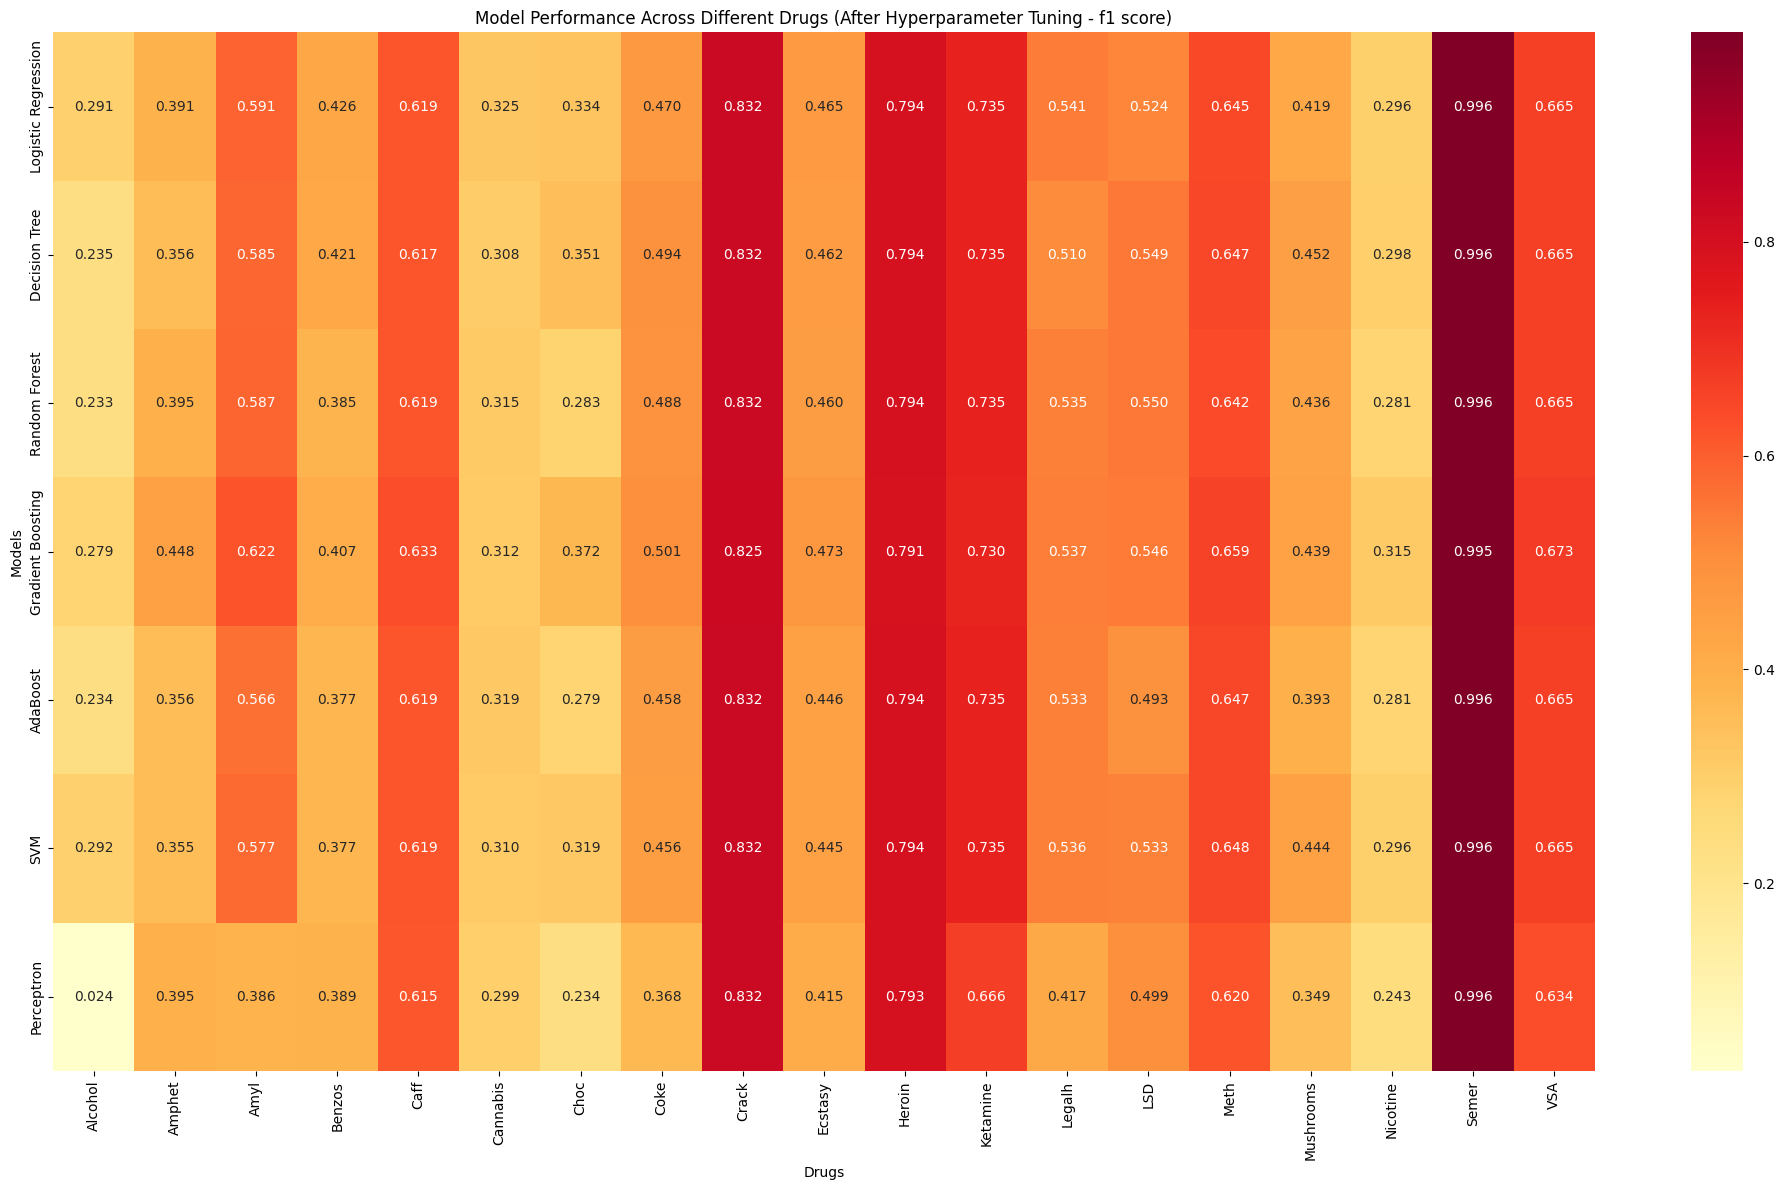

In [15]:
plt.figure(figsize=(20, 12))
sns.heatmap(f1_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Model Performance Across Different Drugs (After Hyperparameter Tuning - f1 score)')
plt.ylabel('Models')
plt.xlabel('Drugs')
plt.tight_layout()
plt.show()

In [16]:
with open('best_parameters.txt', 'w') as f:
    for drug in drug_columns:
        f.write(f"\n{drug} Best Parameters:\n")
        f.write("="*50 + "\n")
        for model, params in all_best_params[drug].items():
            f.write(f"\n{model}:\n")
            f.write(str(params))
            f.write("\n")

In [21]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

def train_and_save_best_models(X, y, drug_name, best_params):
    """
    Train models with best parameters and save them
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Logistic Regression': LogisticRegression(**best_params['Logistic Regression']),
        'Decision Tree': DecisionTreeClassifier(**best_params['Decision Tree']),
        'Random Forest': RandomForestClassifier(**best_params['Random Forest']),
        'Gradient Boosting': GradientBoostingClassifier(**best_params['Gradient Boosting']),
        'AdaBoost': AdaBoostClassifier(**best_params['AdaBoost']),
        'SVM': SVC(**best_params['SVM']),
        'Perceptron': Perceptron(**best_params['Perceptron'])
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name} for {drug_name} with best parameters")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1
        }
        
        # Save the model
        model_filename = f'saved_models/{drug_name}_{name.replace(" ", "_")}.joblib'
        joblib.dump(model, model_filename)
        
        print(f"Model saved as: {model_filename}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return results

In [22]:
final_results = {}

X = df[feature_columns]
for drug in drug_columns:
    print(f"\n{'='*50}")
    print(f"Training and saving models for {drug}")
    print('='*50)
    
    y = df[drug]
    results = train_and_save_best_models(X, y, drug, all_best_params[drug])
    final_results[drug] = results


Training and saving models for Alcohol

Training Logistic Regression for Alcohol with best parameters
Model saved as: saved_models/Alcohol_Logistic_Regression.joblib
Accuracy: 0.3926
F1 Score: 0.2911

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         7
         CL1       0.00      0.00      0.00         7
         CL2       0.00      0.00      0.00        16
         CL3       0.17      0.06      0.09        34
         CL4       0.00      0.00      0.00        68
         CL5       0.41      0.84      0.56       153
         CL6       0.33      0.18      0.24        92

    accuracy                           0.39       377
   macro avg       0.13      0.16      0.13       377
weighted avg       0.26      0.39      0.29       377


Training Decision Tree for Alcohol with best parameters
Model saved as: saved_models/Alcohol_Decision_Tree.joblib
Accuracy: 0.4058
F1 Score: 0.2348

Classification Report:
     

In [23]:
def load_and_evaluate_models():
    print("\nModel Evaluation Results")
    print("=" * 80)
    
    # Get list of all saved model files
    model_files = sorted(os.listdir('saved_models'))
    
    # Load and evaluate each model
    for file in model_files:
        # Extract drug name and model type from filename
        drug_name = file.split('_')[0]
        model_type = '_'.join(file.split('_')[1:]).replace('.joblib', '')
        
        # Load the model
        model_path = os.path.join('saved_models', file)
        model = joblib.load(model_path)
        
        # Get predictions and calculate metrics
        X = df[feature_columns]
        y = df[drug_name]
        y_pred = model.predict(X)
        
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')
        
        print(f"\nDrug: {drug_name}")
        print(f"Model: {model_type}")
        print("-" * 50)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y, y_pred))
        print("=" * 80)

# Load and evaluate all models
load_and_evaluate_models()


Model Evaluation Results

Drug: Alcohol
Model: AdaBoost
--------------------------------------------------
Accuracy: 0.4027
F1 Score: 0.2312

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00        34
         CL1       0.00      0.00      0.00        34
         CL2       0.00      0.00      0.00        68
         CL3       0.00      0.00      0.00       198
         CL4       0.00      0.00      0.00       287
         CL5       0.40      1.00      0.57       759
         CL6       0.00      0.00      0.00       505

    accuracy                           0.40      1885
   macro avg       0.06      0.14      0.08      1885
weighted avg       0.16      0.40      0.23      1885


Drug: Alcohol
Model: Decision_Tree
--------------------------------------------------
Accuracy: 0.4048
F1 Score: 0.2353

Classification Report:
              precision    recall  f1-score   support

         CL0       0.44      0.12    

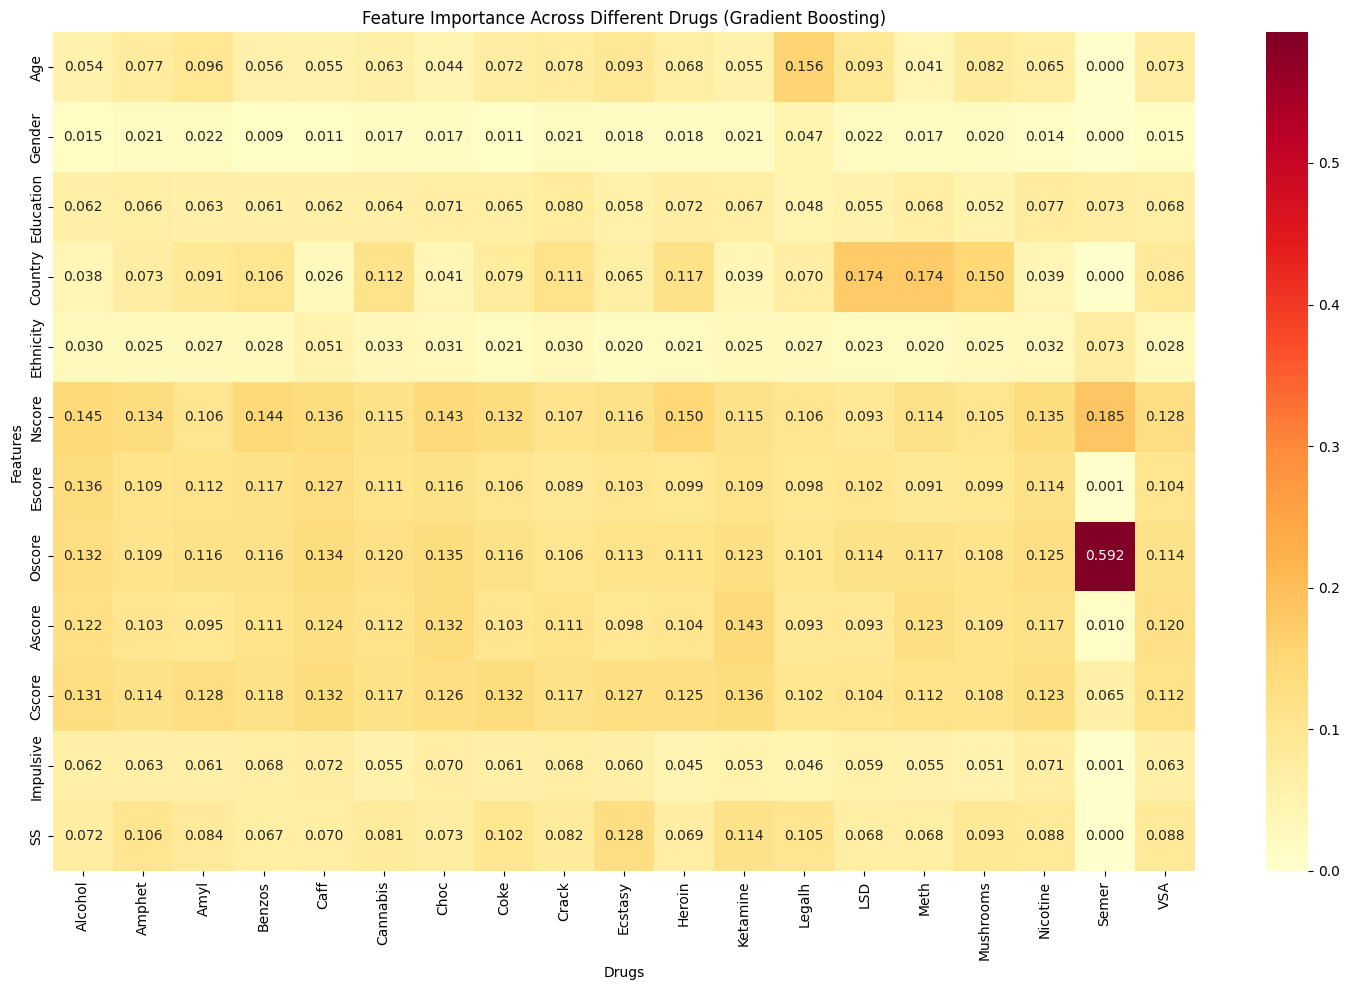

In [17]:
def plot_feature_importance():
    plt.figure(figsize=(15, 10))
    importance_data = {}
    
    for drug in drug_columns:
        # Get the best Gradient Boosting model parameters
        best_params = all_best_params[drug]['Gradient Boosting']
        
        # Create and train a Gradient Boosting model with best parameters
        rf_model = GradientBoostingClassifier(**best_params, random_state=42)
        rf_model.fit(X, df[drug])
        
        # Store feature importance
        importance_data[drug] = rf_model.feature_importances_
    
    # Create DataFrame for feature importance
    importance_df = pd.DataFrame(importance_data, index=feature_columns)
    
    # Plot heatmap
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd', fmt='.3f')
    plt.title('Feature Importance Across Different Drugs (Gradient Boosting)')
    plt.ylabel('Features')
    plt.xlabel('Drugs')
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance()

In [24]:
if not os.path.exists('saved_models_with_drug_features'):
    os.makedirs('saved_models_with_drug_features')

def train_and_save_models_with_drug_features(df, drug_columns, feature_columns):
    all_results = {}
    all_feature_importance = {}
    
    for target_drug in drug_columns:
        print(f"\n{'='*50}")
        print(f"Processing {target_drug}...")
        print('='*50)
        
        # Get other drugs as features
        other_drugs = [drug for drug in drug_columns if drug != target_drug]
        feature_drug_columns = feature_columns + other_drugs
        
        # Prepare the data
        X = df[feature_drug_columns].copy()
        y = df[target_drug]
        
        # Label Encoding for other drugs
        le = LabelEncoder()
        for drug in other_drugs:
            X[drug] = le.fit_transform(X[drug])
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        drug_results = {}
        
        # Define models
        models = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'Gradient Boosting': GradientBoostingClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'SVM': SVC(),
            'Perceptron': Perceptron()
        }
        
        # Train and evaluate each model
        for name, model in models.items():
            print(f"\nTraining {name} for {target_drug}")
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Save the model
            model_filename = f'saved_models_with_drug_features/{target_drug}_{name.replace(" ", "_")}.joblib'
            joblib.dump(model, model_filename)
            
            # Make predictions and evaluate
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            drug_results[name] = {
                'accuracy': accuracy,
                'f1_score': f1,
                'classification_report': classification_report(y_test, y_pred)
            }
            
            print(f"Model saved as: {model_filename}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))
            
            # Store feature importance for Gradient Boosting
            if name == 'Gradient Boosting':
                feature_importance = pd.Series(model.feature_importances_, index=feature_drug_columns)
                all_feature_importance[target_drug] = feature_importance
        
        all_results[target_drug] = drug_results
    
    return all_results, all_feature_importance


In [25]:
print("Training and saving models...")
results, feature_importance = train_and_save_models_with_drug_features(df, drug_columns, feature_columns)


Training and saving models...

Processing Alcohol...

Training Logistic Regression for Alcohol
Model saved as: saved_models_with_drug_features/Alcohol_Logistic_Regression.joblib
Accuracy: 0.3979
F1 Score: 0.3219

Classification Report:
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         7
         CL1       0.00      0.00      0.00         7
         CL2       0.00      0.00      0.00        16
         CL3       0.20      0.12      0.15        34
         CL4       0.25      0.03      0.05        68
         CL5       0.44      0.80      0.57       153
         CL6       0.35      0.24      0.28        92

    accuracy                           0.40       377
   macro avg       0.18      0.17      0.15       377
weighted avg       0.33      0.40      0.32       377


Training Decision Tree for Alcohol
Model saved as: saved_models_with_drug_features/Alcohol_Decision_Tree.joblib
Accuracy: 0.2838
F1 Score: 0.2864

Classification Repo

In [28]:
accuracy_dict = {}
f1_dict = {}

for drug in results:
    accuracy_dict[drug] = {}
    f1_dict[drug] = {}
    for model_name, metrics in results[drug].items():
        accuracy_dict[drug][model_name] = metrics['accuracy']
        f1_dict[drug][model_name] = metrics['f1_score']

# Convert to DataFrames
accuracy_df = pd.DataFrame(accuracy_dict)
f1_df = pd.DataFrame(f1_dict)

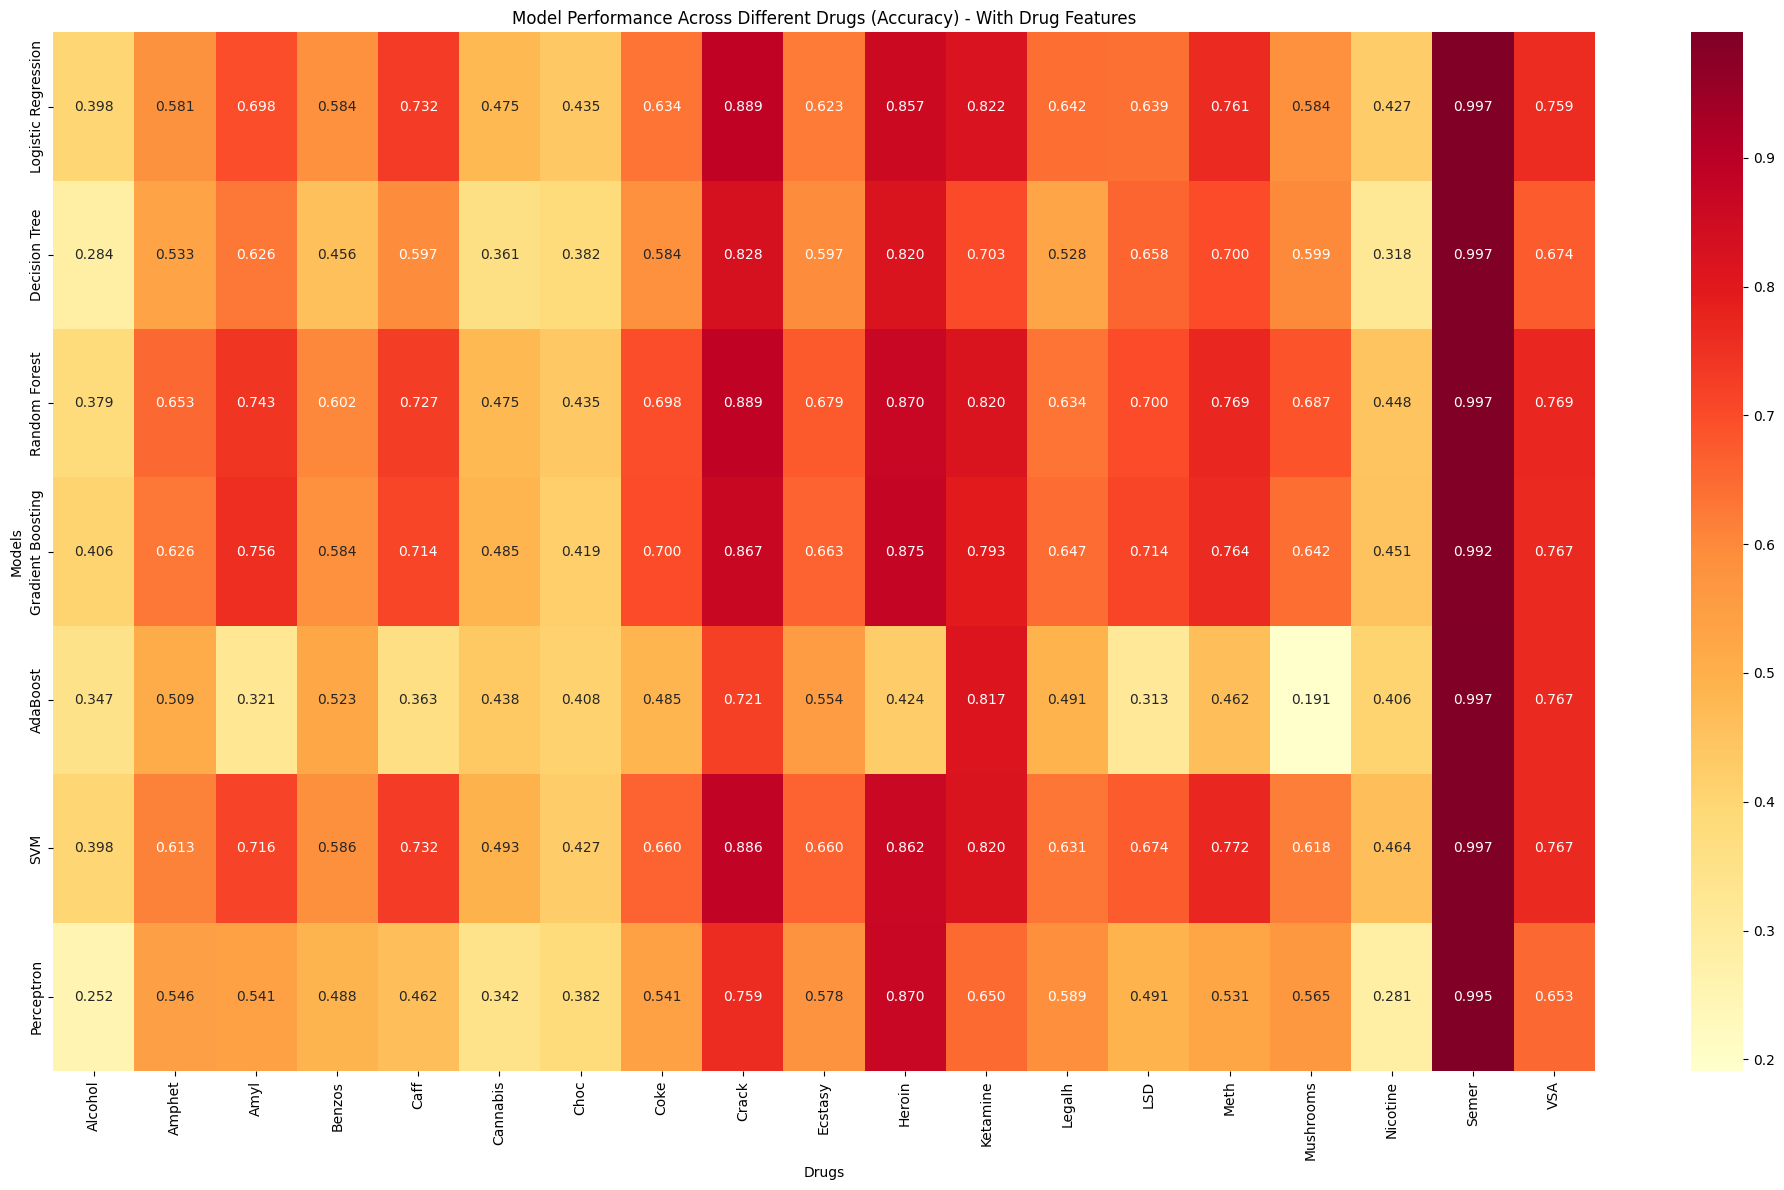

In [29]:
plt.figure(figsize=(20, 12))
sns.heatmap(accuracy_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Model Performance Across Different Drugs (Accuracy) - With Drug Features')
plt.ylabel('Models')
plt.xlabel('Drugs')
plt.tight_layout()
plt.show()

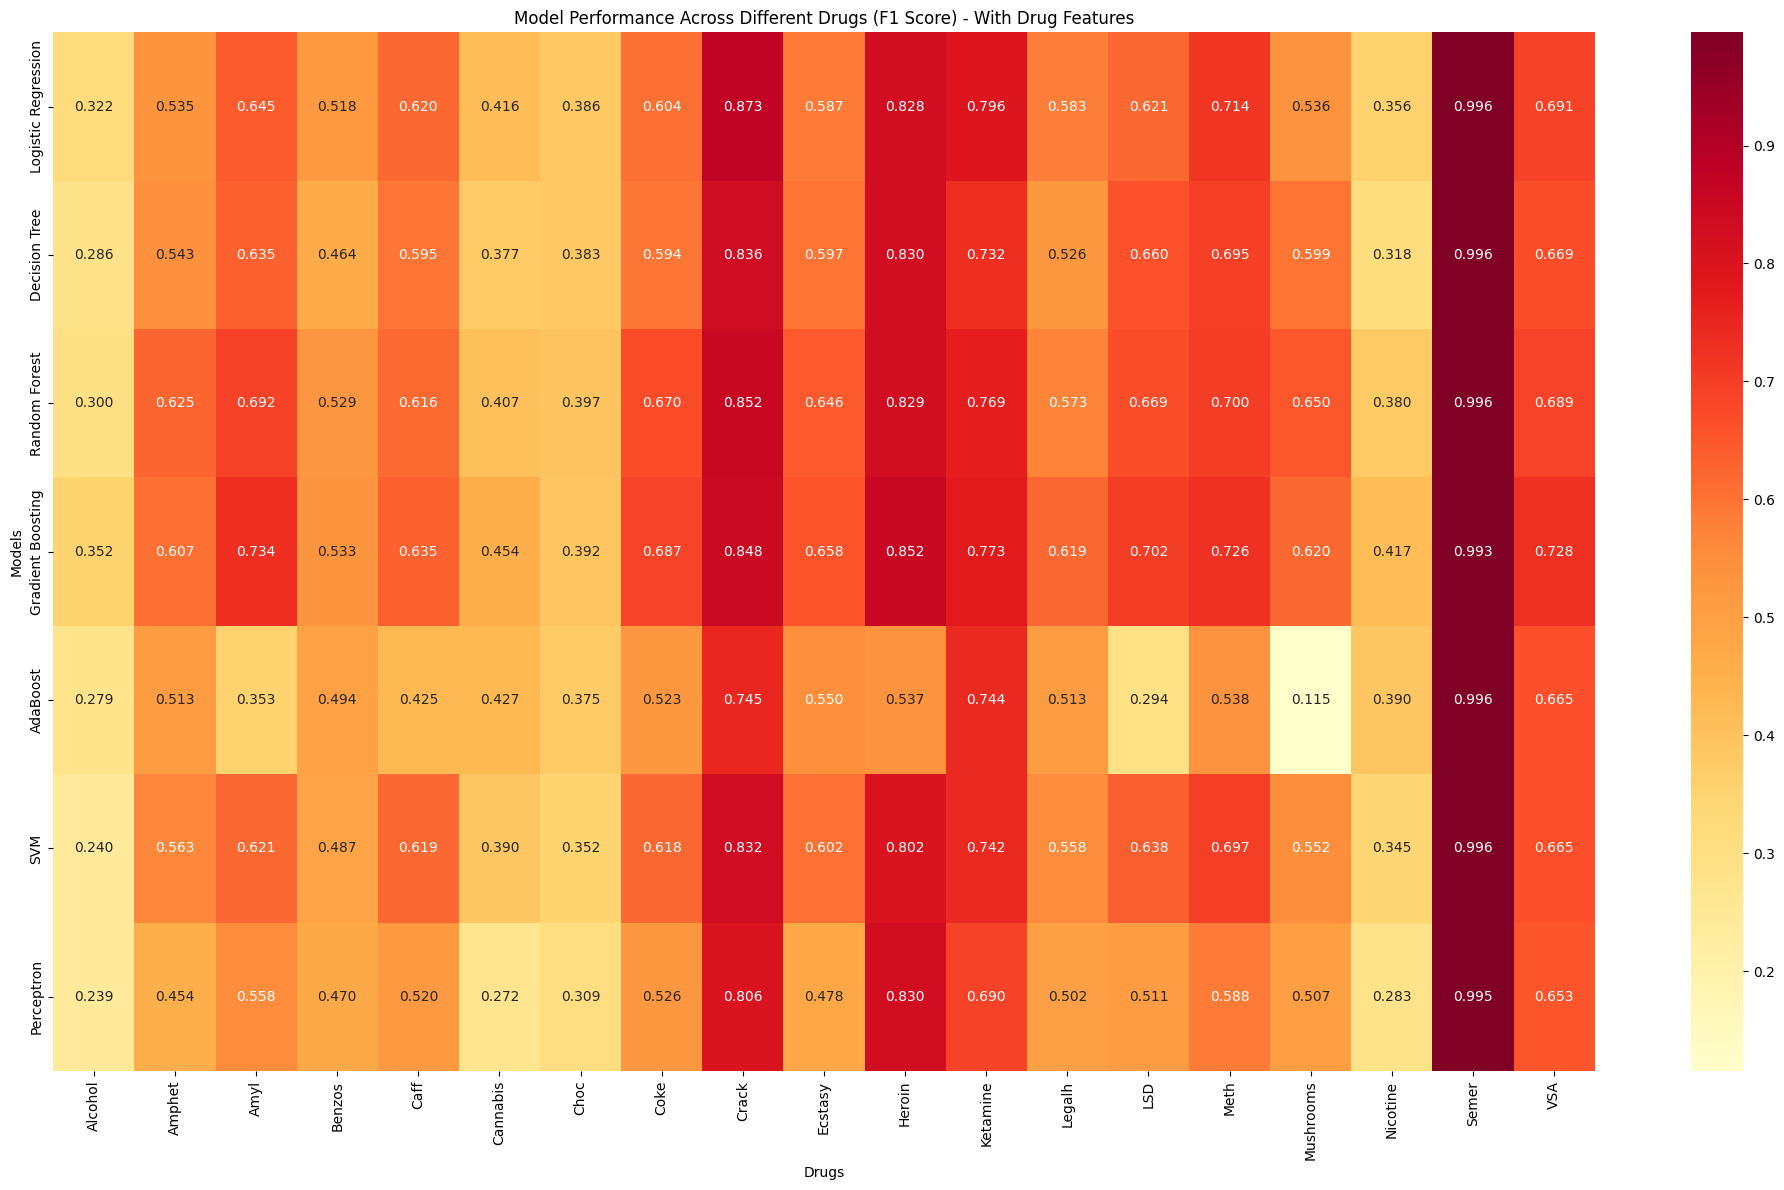

In [30]:
plt.figure(figsize=(20, 12))
sns.heatmap(f1_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Model Performance Across Different Drugs (F1 Score) - With Drug Features')
plt.ylabel('Models')
plt.xlabel('Drugs')
plt.tight_layout()
plt.show()

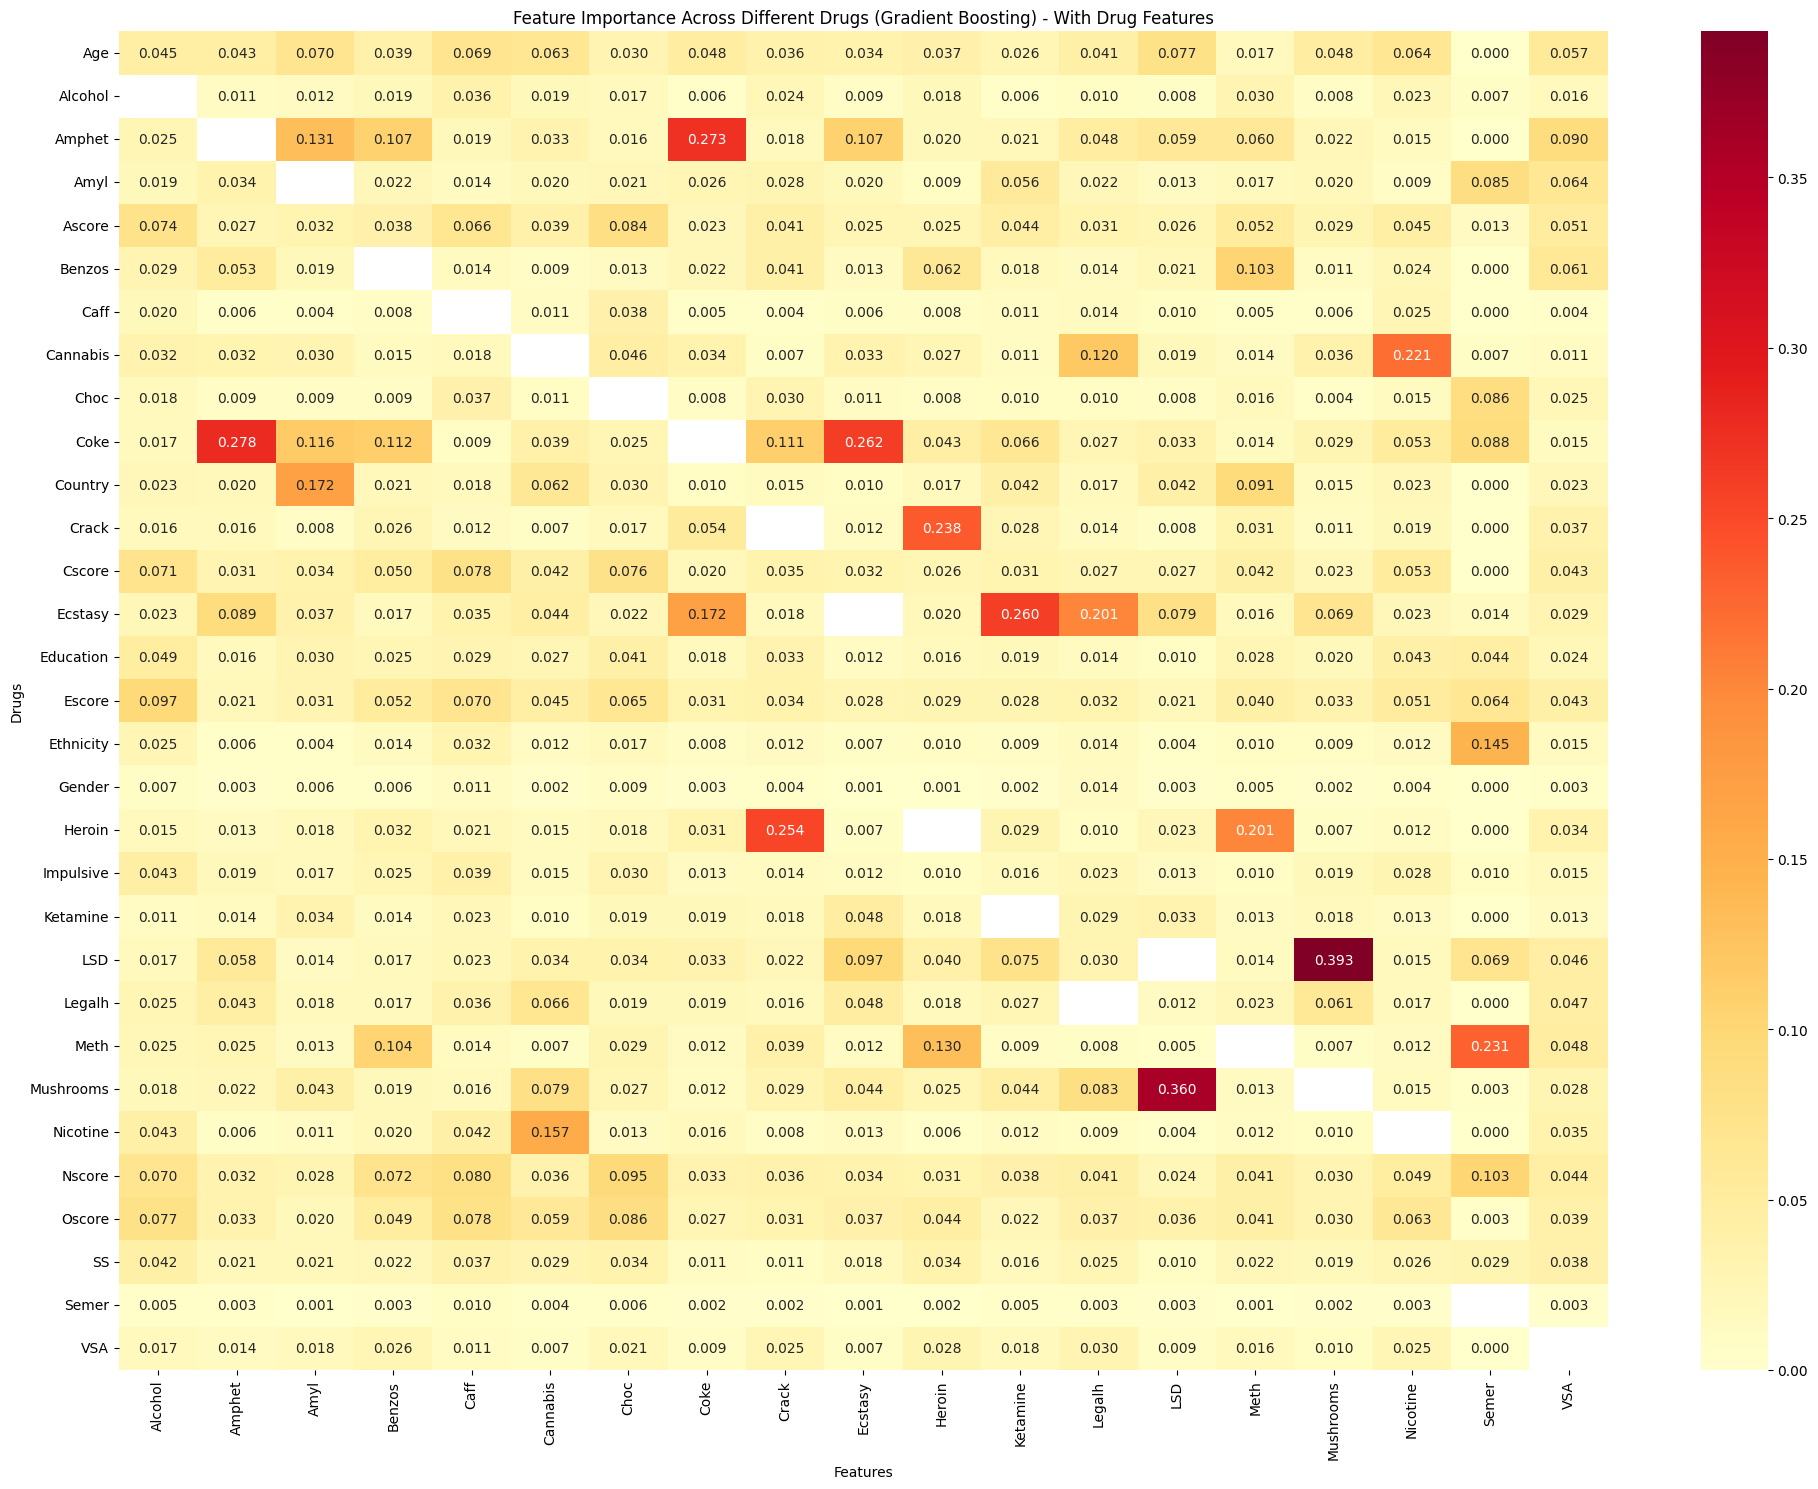

In [33]:
importance_df = pd.DataFrame(feature_importance)
  
# Plot feature importance heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(importance_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Feature Importance Across Different Drugs (Gradient Boosting) - With Drug Features')
plt.ylabel('Drugs')
plt.xlabel('Features')
plt.tight_layout()
plt.show()



In [26]:
def load_and_evaluate_models_with_drug_features(df, drug_columns, feature_columns):
    print("\nEvaluating Models with Drug Features")
    print("=" * 80)
    
    # Get list of all saved model files
    model_files = sorted(os.listdir('saved_models_with_drug_features'))
    
    for file in model_files:
        # Extract drug name and model type from filename
        drug_name = file.split('_')[0]
        model_type = '_'.join(file.split('_')[1:]).replace('.joblib', '')
        
        # Load the model
        model_path = os.path.join('saved_models_with_drug_features', file)
        model = joblib.load(model_path)
        
        # Prepare the data
        other_drugs = [drug for drug in drug_columns if drug != drug_name]
        feature_drug_columns = feature_columns + other_drugs
        X = df[feature_drug_columns].copy()
        y = df[drug_name]
        
        # Label Encoding for other drugs
        le = LabelEncoder()
        for drug in other_drugs:
            X[drug] = le.fit_transform(X[drug])
        
        # Make predictions and evaluate
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')
        
        print(f"\nDrug: {drug_name}")
        print(f"Model: {model_type}")
        print("-" * 50)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y, y_pred))
        print("=" * 80)


In [27]:
print("\nLoading and evaluating models...")
load_and_evaluate_models_with_drug_features(df, drug_columns, feature_columns)



Loading and evaluating models...

Evaluating Models with Drug Features

Drug: Alcohol
Model: AdaBoost
--------------------------------------------------
Accuracy: 0.3729
F1 Score: 0.3156

Classification Report:
              precision    recall  f1-score   support

         CL0       0.24      0.24      0.24        34
         CL1       0.06      0.06      0.06        34
         CL2       0.18      0.03      0.05        68
         CL3       0.24      0.13      0.17       198
         CL4       0.25      0.02      0.04       287
         CL5       0.41      0.71      0.52       759
         CL6       0.33      0.24      0.27       505

    accuracy                           0.37      1885
   macro avg       0.24      0.20      0.19      1885
weighted avg       0.33      0.37      0.32      1885


Drug: Alcohol
Model: Decision_Tree
--------------------------------------------------
Accuracy: 0.8568
F1 Score: 0.8569

Classification Report:
              precision    recall  f1-score   